<h1>NR-AhR</h1>

In [3]:
#Da far andare su Colab
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/My Drive/dati_AML"

!pip install gpyopt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
hyp_1.txt		    NR-ER_wholetraining_x.txt
hyp_2.txt		    NR-ER_wholetraining_y.txt
hyp_4.txt		    SR-ARE_score_x.txt
hyp_5.txt		    SR-ARE_score_y.txt
hyp_6.txt		    SR-ARE_test_x.txt
NR-AhR_score_x.txt	    SR-ARE_test_y.txt
NR-AhR_score_y.txt	    SR-ARE_train_x.txt
NR-AhR_test_x.txt	    SR-ARE_train_y.txt
NR-AhR_test_y.txt	    SR-ARE_wholetraining_x.txt
NR-AhR_train_x.txt	    SR-ARE_wholetraining_y.txt
NR-AhR_train_y.txt	    SR-MMP_score_x.txt
NR-AhR_wholetraining_x.txt  SR-MMP_score_y.txt
NR-AhR_wholetraining_y.txt  SR-MMP_test_x.txt
NR-ER_score_x.txt	    SR-MMP_test_y.txt
NR-ER_score_y.txt	    SR-MMP_train_x.txt
NR-ER_test_x.txt	    SR-MMP_train_y.txt
NR-ER_test_y.txt	    SR-MMP_wholetraining_x.txt
NR-ER_train_x.txt	    SR-MMP_wholetraining_y.txt
NR-ER_train_y.txt


In [4]:
#Import

import json

import numpy as np
from numpy.random import seed
seed(1234)


import GPyOpt

import seaborn as sbn

from imblearn.over_sampling import RandomOverSampler, SMOTENC

import collections

from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Conv2D, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils import class_weight

Using TensorFlow backend.


In [5]:
#Train

with open('/content/drive/My Drive/dati_AML/NR-AhR_wholetraining_x.txt', 'r') as f:
    NR_AhR_wholetraining_x = json.loads(f.read())

with open('/content/drive/My Drive/dati_AML/NR-AhR_wholetraining_y.txt', 'r') as f:
    NR_AhR_wholetraining_y = json.loads(f.read())

X = np.array(NR_AhR_wholetraining_x)
Y = np.array(NR_AhR_wholetraining_y)

#Score

with open('/content/drive/My Drive/dati_AML/NR-AhR_score_x.txt', 'r') as f:
    NR_AhR_score_x = json.loads(f.read())

with open('/content/drive/My Drive/dati_AML/NR-AhR_score_y.txt', 'r') as f:
    NR_AhR_score_y = json.loads(f.read())

NR_AhR_score_x = np.array(NR_AhR_score_x)
NR_AhR_score_y = np.array(NR_AhR_score_y)

In [6]:
#Def funzioni

def metrics():

    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')]
  
    return(METRICS)

def plot_auc(history):
    fig, ax1 = plt.subplots()
    ax1.plot(history.epoch, history.history['auc'],c='b', label="Train")
    ax1.plot(history.epoch, history.history['val_auc'],c='g', label="Val")
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('AUC')
    plt.legend()
    plt.show()

def plot_rec(history):
    fig, ax1 = plt.subplots()
    ax1.plot(history.epoch, history.history['recall'],c='b', label="Train")
    ax1.plot(history.epoch, history.history['val_recall'],c='g', label="Val")
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Recall')
    plt.legend()
    plt.show()
    
def plot_prec(history):
    fig, ax1 = plt.subplots()
    ax1.plot(history.epoch, history.history['precision'],c='b', label="Train")
    ax1.plot(history.epoch, history.history['val_precision'],c='g', label="Val")
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Precision')
    plt.legend()
    plt.show()
    

def plot_loss(history):
    fig, ax1 = plt.subplots()
    ax1.plot(history.epoch, history.history['loss'],c='b', label="Train")
    ax1.plot(history.epoch, history.history['val_loss'],c='g', label="Val")
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('LOSS')
    plt.legend()
    plt.show()

<h1>Modelli</h1>

Viene effettuata un'analisi esplorativa, attraverso l'applicazione di diverse architetture, al fine di identificare i parametri che influenzano maggiormente le performances.

<h3>Modello 1<h3>

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X, Y):
    
    modello = Sequential()
    modello.add(Conv1D(100, kernel_size=(10), activation='relu', padding = 'same'))
    modello.add(keras.layers.GlobalMaxPooling1D())
    modello.add(Dense(64, activation = 'relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=metrics())

    history = modello.fit(X[train], Y[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X[test], Y[test])) 
    
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))


Train on 4625 samples, validate on 2313 samples
Epoch 1/80
4625/4625 [==============================] - 3s 589us/step - loss: 0.3651 - tp: 25.0000 - fp: 231.0000 - tn: 3879.0000 - fn: 490.0000 - accuracy: 0.8441 - precision: 0.0977 - recall: 0.0485 - auc: 0.6352 - val_loss: 0.3153 - val_tp: 37.0000 - val_fp: 29.0000 - val_tn: 2027.0000 - val_fn: 220.0000 - val_accuracy: 0.8923 - val_precision: 0.5606 - val_recall: 0.1440 - val_auc: 0.8123
Epoch 2/80
4625/4625 [==============================] - 1s 272us/step - loss: 0.3001 - tp: 27.0000 - fp: 27.0000 - tn: 4083.0000 - fn: 488.0000 - accuracy: 0.8886 - precision: 0.5000 - recall: 0.0524 - auc: 0.7788 - val_loss: 0.2796 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2056.0000 - val_fn: 257.0000 - val_accuracy: 0.8889 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8286
Epoch 3/80
4625/4625 [==============================] - 1s 267us/step - loss: 0.2667 - tp: 58.0000 - fp: 26.0000 - tn: 4084.0000 - fn: 457.0000 - acc

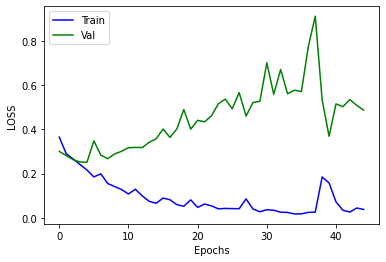

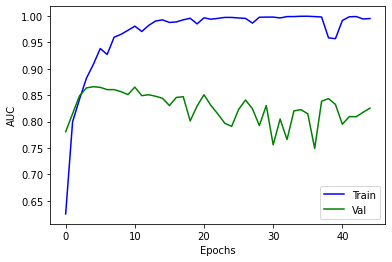

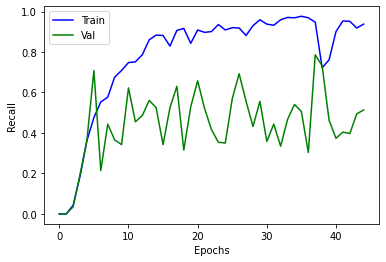

In [ ]:
plot_loss(history)
plot_auc(history)
plot_rec(history)


In [ ]:
y_pred = modello.predict(NR_AhR_score_x)
y_pred = y_pred.round()
NR_AhR_score_y_int = [int(i) for i in NR_AhR_score_y]
print(classification_report(NR_AhR_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       537
           1       0.45      0.35      0.40        71

    accuracy                           0.88       608
   macro avg       0.69      0.65      0.66       608
weighted avg       0.86      0.88      0.87       608



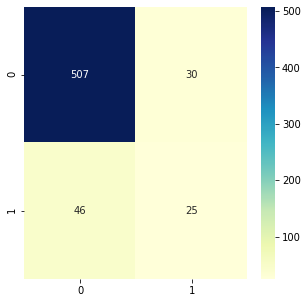

In [ ]:
cm = confusion_matrix(NR_AhR_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_AhR_score_x,NR_AhR_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

608/608 [==============================] - 0s 200us/step
Evaluation metrics:
	loss:	0.27816926491887944
	tp:	25.0
	fp:	30.0
	tn:	507.0
	fn:	46.0
	accuracy:	0.875
	precision:	0.4545454680919647
	recall:	0.35211268067359924
	auc:	0.8559682369232178



<h3>Modello 2 </h3>

Rispetto alla rete precedente, viene valutato l'utilizzo del Dropout come primo layer. 

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X, Y):
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(100, kernel_size=(10), activation='relu', padding = 'same'))
    modello.add(keras.layers.GlobalMaxPooling1D())
    modello.add(Dense(64, activation = 'relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=metrics())

    history = modello.fit(X[train], Y[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X[test], Y[test])) 
    
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))

    

Train on 4625 samples, validate on 2313 samples
Epoch 1/80
4625/4625 [==============================] - 2s 347us/step - loss: 0.3480 - tp: 3.0000 - fp: 6.0000 - tn: 4104.0000 - fn: 512.0000 - accuracy: 0.8880 - precision: 0.3333 - recall: 0.0058 - auc: 0.6594 - val_loss: 0.3065 - val_tp: 7.0000 - val_fp: 11.0000 - val_tn: 2045.0000 - val_fn: 250.0000 - val_accuracy: 0.8872 - val_precision: 0.3889 - val_recall: 0.0272 - val_auc: 0.7724
Epoch 2/80
4625/4625 [==============================] - 1s 267us/step - loss: 0.2876 - tp: 31.0000 - fp: 28.0000 - tn: 4082.0000 - fn: 484.0000 - accuracy: 0.8893 - precision: 0.5254 - recall: 0.0602 - auc: 0.8018 - val_loss: 0.2973 - val_tp: 48.0000 - val_fp: 64.0000 - val_tn: 1992.0000 - val_fn: 209.0000 - val_accuracy: 0.8820 - val_precision: 0.4286 - val_recall: 0.1868 - val_auc: 0.8129
Epoch 3/80
4625/4625 [==============================] - 1s 261us/step - loss: 0.2660 - tp: 86.0000 - fp: 55.0000 - tn: 4055.0000 - fn: 429.0000 - accuracy: 0.8954 - pr

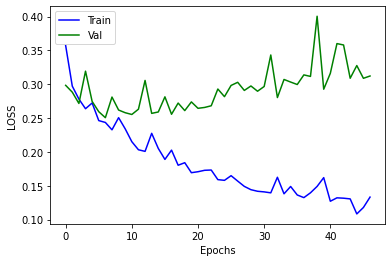

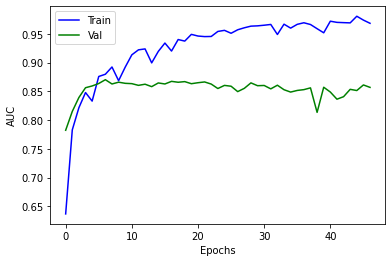

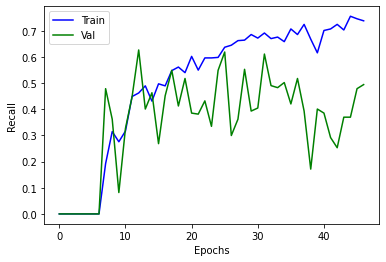

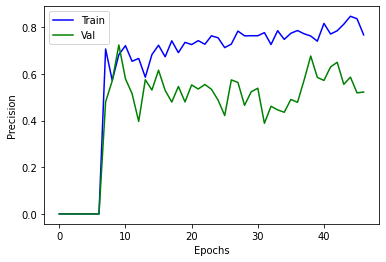

In [ ]:
plot_loss(history)
plot_auc(history)
plot_rec(history)
plot_prec(history)


In [ ]:
y_pred = modello.predict(NR_AhR_score_x)
y_pred = y_pred.round()
NR_AhR_score_y_int = [int(i) for i in NR_AhR_score_y]
print(classification_report(NR_AhR_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       537
           1       0.00      0.00      0.00        71

    accuracy                           0.88       608
   macro avg       0.44      0.50      0.47       608
weighted avg       0.78      0.88      0.83       608



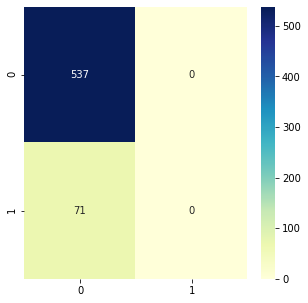

In [ ]:
cm = confusion_matrix(NR_AhR_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_AhR_score_x,NR_AhR_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

608/608 [==============================] - 0s 205us/step
Evaluation metrics:
	loss:	0.2732101741589998
	tp:	0.0
	fp:	0.0
	tn:	537.0
	fn:	71.0
	accuracy:	0.8832237124443054
	precision:	0.0
	recall:	0.0
	auc:	0.8616728186607361



<h3>Modello 3</h3>

In questo caso, viene testato l'effetto di un maggior numero di convoluzioni, con l'aggiunta di un Global Average Pooling prima del layer fully connected.

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X, Y):  
    
    
    modello = Sequential()
    modello.add(Conv1D(100, kernel_size=(10), activation='relu', padding = 'same'))
    modello.add(keras.layers.MaxPooling1D(pool_size=5, strides=None, padding="same"))
    modello.add(Conv1D(100, kernel_size=(10), activation = 'relu', padding = 'same'))
    modello.add(keras.layers.MaxPooling1D(pool_size=5, strides=None, padding="same"))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(64, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=metrics())

    history = modello.fit(X[train], Y[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X[test], Y[test]))
    
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))

    

Train on 4625 samples, validate on 2313 samples
Epoch 1/80
4625/4625 [==============================] - 2s 456us/step - loss: 0.3849 - tp: 0.0000e+00 - fp: 4.0000 - tn: 4106.0000 - fn: 515.0000 - accuracy: 0.8878 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5943 - val_loss: 0.3055 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2056.0000 - val_fn: 257.0000 - val_accuracy: 0.8889 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7760
Epoch 2/80
4625/4625 [==============================] - 1s 267us/step - loss: 0.3147 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4110.0000 - fn: 515.0000 - accuracy: 0.8886 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7412 - val_loss: 0.3007 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2056.0000 - val_fn: 257.0000 - val_accuracy: 0.8889 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7853
Epoch 3/80
4625/4625 [==============================] - 1s 269us/step - loss: 0.3066 - tp: 0.0000e+00 - fp: 0.00

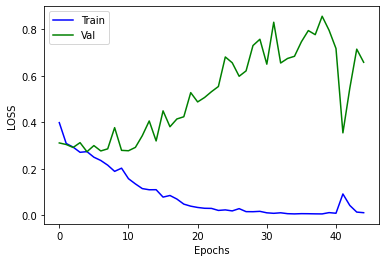

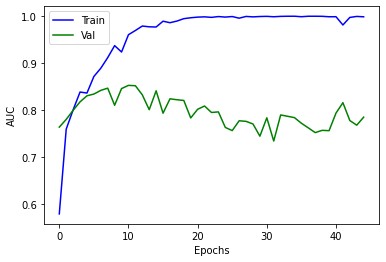

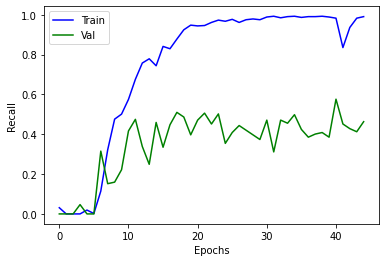

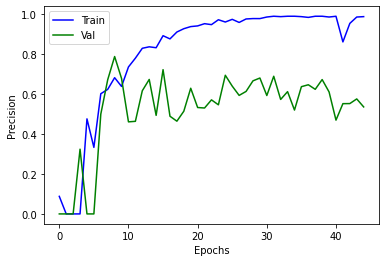

In [ ]:
plot_loss(history)
plot_auc(history)
plot_rec(history)
plot_prec(history)


In [ ]:
y_pred = modello.predict(NR_AhR_score_x)
y_pred = y_pred.round()
NR_AhR_score_y_int = [int(i) for i in NR_AhR_score_y]
print(classification_report(NR_AhR_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       537
           1       0.00      0.00      0.00        71

    accuracy                           0.88       608
   macro avg       0.44      0.50      0.47       608
weighted avg       0.78      0.88      0.83       608



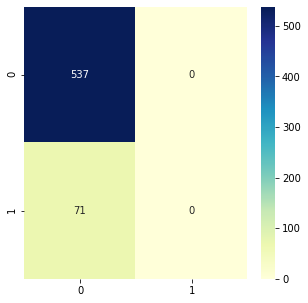

In [ ]:
cm = confusion_matrix(NR_AhR_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_AhR_score_x,NR_AhR_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

608/608 [==============================] - 0s 208us/step
Evaluation metrics:
	loss:	0.27526234678531947
	tp:	0.0
	fp:	0.0
	tn:	537.0
	fn:	71.0
	accuracy:	0.8832237124443054
	precision:	0.0
	recall:	0.0
	auc:	0.8575418591499329



<h3>Modello 4</h3>

Viene riproposta la rete con una sola convoluzione, Dropout iniziale ed un lavyer di Global Averege Pooling come connessione con il layer fully connected. <br><br>
L'architettura risulta piuttosto interessante, dato il livello di recall raggiunto sullo score, nonostante lo sbilanciamento. L'andamento crescente del parametro 'recall', se pur presente una notevole variabilità, è chiaramente visibile dal plot. 

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X, Y):   
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(100, kernel_size=(10), activation='relu', padding = 'same'))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(64, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=metrics())

    history = modello.fit(X[train], Y[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X[test], Y[test]))
    
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))

    

Train on 4625 samples, validate on 2313 samples
Epoch 1/80
4625/4625 [==============================] - 1s 322us/step - loss: 0.4119 - tp: 6.0000 - fp: 110.0000 - tn: 4000.0000 - fn: 509.0000 - accuracy: 0.8662 - precision: 0.0517 - recall: 0.0117 - auc: 0.5168 - val_loss: 0.3249 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2056.0000 - val_fn: 257.0000 - val_accuracy: 0.8889 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7406
Epoch 2/80
4625/4625 [==============================] - 1s 250us/step - loss: 0.3233 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4110.0000 - fn: 515.0000 - accuracy: 0.8886 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7074 - val_loss: 0.3175 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2056.0000 - val_fn: 257.0000 - val_accuracy: 0.8889 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7585
Epoch 3/80
4625/4625 [==============================] - 1s 244us/step - loss: 0.3164 - tp: 0.0000e+00 - fp: 0.0000e+00 - t

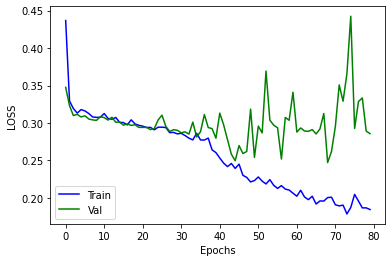

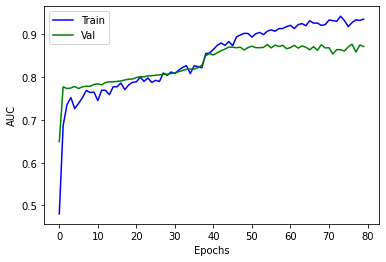

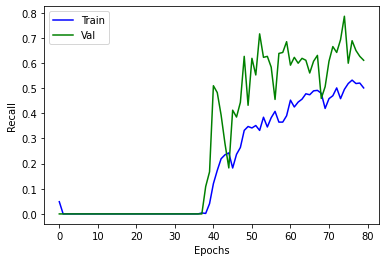

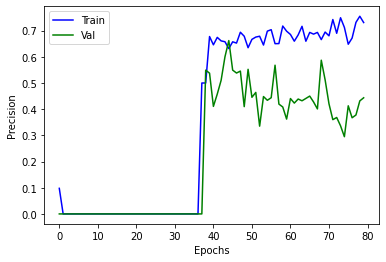

In [ ]:
plot_loss(history)
plot_auc(history)
plot_rec(history)
plot_prec(history)


In [ ]:
y_pred = modello.predict(NR_AhR_score_x)
y_pred = y_pred.round()
NR_AhR_score_y_int = [int(i) for i in NR_AhR_score_y]
print(classification_report(NR_AhR_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.95      0.87      0.90       537
           1       0.38      0.62      0.47        71

    accuracy                           0.84       608
   macro avg       0.66      0.74      0.69       608
weighted avg       0.88      0.84      0.85       608



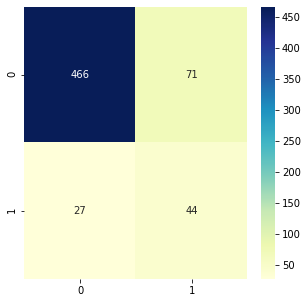

In [ ]:
cm = confusion_matrix(NR_AhR_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_AhR_score_x,NR_AhR_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

608/608 [==============================] - 0s 236us/step
Evaluation metrics:
	loss:	0.34808441133875595
	tp:	44.0
	fp:	71.0
	tn:	466.0
	fn:	27.0
	accuracy:	0.8388158082962036
	precision:	0.38260868191719055
	recall:	0.6197183132171631
	auc:	0.8559157848358154



<h3>Modello 5</h3>

Di seguito, viene testato l'effetto del Dropout come primo layer sulla rete con due convoluzioni. Anche in questo caso, si ottiene un buon livello di recall, nonostante si veda che il valore della loss cominci a crescere prima che il livello di recall massimo sia raggiunto.

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X, Y):    
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(100, kernel_size=(10), activation='relu', padding = 'same'))
    modello.add(keras.layers.AveragePooling1D(pool_size=5, strides=None, padding="same"))
    modello.add(Conv1D(100, kernel_size=(10), activation = 'relu', padding = 'same'))
    modello.add(keras.layers.AveragePooling1D(pool_size=5, strides=None, padding="same"))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(64, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=metrics())

    history = modello.fit(X[train], Y[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X[test], Y[test])) 
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))

    

Train on 4625 samples, validate on 2313 samples
Epoch 1/80
4625/4625 [==============================] - 8s 2ms/step - loss: 0.3776 - tp: 0.0000e+00 - fp: 46.0000 - tn: 4064.0000 - fn: 515.0000 - accuracy: 0.8787 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5839 - val_loss: 0.3541 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2056.0000 - val_fn: 257.0000 - val_accuracy: 0.8889 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7852
Epoch 2/80
4625/4625 [==============================] - 1s 263us/step - loss: 0.3295 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4110.0000 - fn: 515.0000 - accuracy: 0.8886 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6879 - val_loss: 0.3055 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2056.0000 - val_fn: 257.0000 - val_accuracy: 0.8889 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7889
Epoch 3/80
4625/4625 [==============================] - 1s 266us/step - loss: 0.3135 - tp: 0.0000e+00 - fp: 0.000

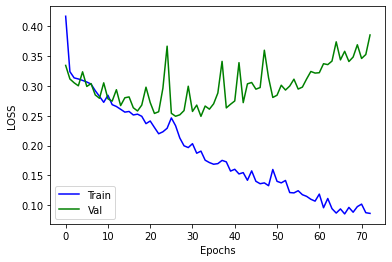

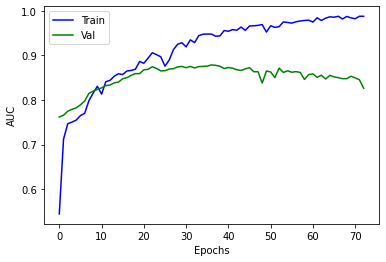

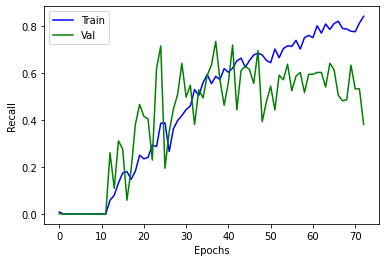

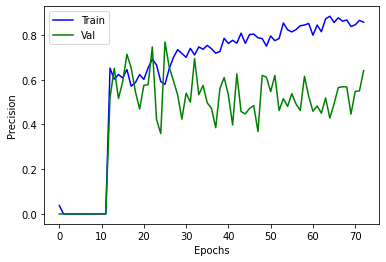

In [ ]:
plot_loss(history)
plot_auc(history)
plot_rec(history)
plot_prec(history)


In [ ]:
y_pred = modello.predict(NR_AhR_score_x)
y_pred = y_pred.round()
NR_AhR_score_y_int = [int(i) for i in NR_AhR_score_y]
print(classification_report(NR_AhR_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       537
           1       0.52      0.34      0.41        71

    accuracy                           0.89       608
   macro avg       0.72      0.65      0.67       608
weighted avg       0.87      0.89      0.88       608



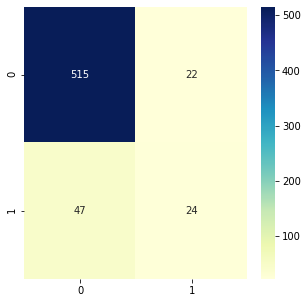

In [ ]:
cm = confusion_matrix(NR_AhR_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_AhR_score_x,NR_AhR_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

608/608 [==============================] - 0s 227us/step
Evaluation metrics:
	loss:	0.27292910688801814
	tp:	24.0
	fp:	22.0
	tn:	515.0
	fn:	47.0
	accuracy:	0.8865131735801697
	precision:	0.52173912525177
	recall:	0.3380281627178192
	auc:	0.8566895723342896



<h3>Modello 6 </h3>

Alla rete con una sola convoluzione, viene aggiunto un fattore di regolarizzazione del kernel.

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X, Y):    
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(100, kernel_size=(10), activation='relu', padding = 'same', kernel_regularizer = keras.regularizers.l2(1e-4)))
    modello.add(keras.layers.AveragePooling1D(pool_size=5, strides=None, padding="same"))
    modello.add(keras.layers.GlobalMaxPooling1D())
    modello.add(Dense(64, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=metrics())

    history = modello.fit(X[train], Y[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X[test], Y[test])) 
    
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))

    

Train on 4625 samples, validate on 2313 samples
Epoch 1/80
4625/4625 [==============================] - 2s 395us/step - loss: 0.3457 - tp: 28.0000 - fp: 182.0000 - tn: 3928.0000 - fn: 487.0000 - accuracy: 0.8554 - precision: 0.1333 - recall: 0.0544 - auc: 0.7055 - val_loss: 0.3176 - val_tp: 39.0000 - val_fp: 54.0000 - val_tn: 2002.0000 - val_fn: 218.0000 - val_accuracy: 0.8824 - val_precision: 0.4194 - val_recall: 0.1518 - val_auc: 0.7787
Epoch 2/80
4625/4625 [==============================] - 1s 293us/step - loss: 0.3053 - tp: 3.0000 - fp: 17.0000 - tn: 4093.0000 - fn: 512.0000 - accuracy: 0.8856 - precision: 0.1500 - recall: 0.0058 - auc: 0.7836 - val_loss: 0.2976 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2056.0000 - val_fn: 257.0000 - val_accuracy: 0.8889 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7924
Epoch 3/80
4625/4625 [==============================] - 1s 298us/step - loss: 0.2989 - tp: 6.0000 - fp: 1.0000 - tn: 4109.0000 - fn: 509.0000 - accura

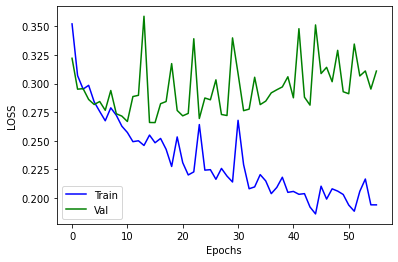

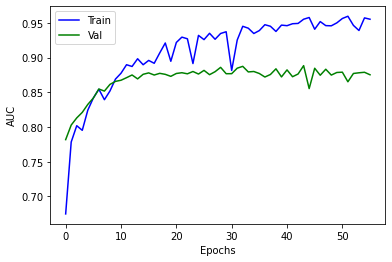

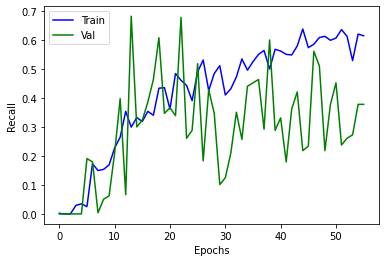

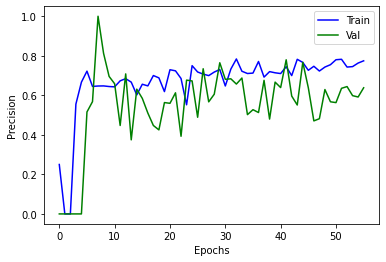

In [ ]:
plot_loss(history)
plot_auc(history)
plot_rec(history)
plot_prec(history)

In [ ]:
y_pred = modello.predict(NR_AhR_score_x)
y_pred = y_pred.round()
NR_AhR_score_y_int = [int(i) for i in NR_AhR_score_y]
print(classification_report(NR_AhR_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       537
           1       0.51      0.38      0.44        71

    accuracy                           0.88       608
   macro avg       0.72      0.67      0.69       608
weighted avg       0.87      0.88      0.88       608



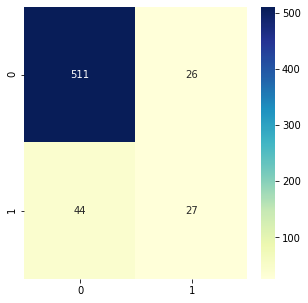

In [ ]:
cm = confusion_matrix(NR_AhR_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_AhR_score_x,NR_AhR_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

608/608 [==============================] - 0s 261us/step
Evaluation metrics:
	loss:	0.2878627353592923
	tp:	27.0
	fp:	26.0
	tn:	511.0
	fn:	44.0
	accuracy:	0.8848684430122375
	precision:	0.5094339847564697
	recall:	0.3802816867828369
	auc:	0.8687937259674072



Alla fine dei test, si nota che la rete nr. 4 è la più  performante in termini di AUC e recall.
<br><br>
Di seguito, vengono introdotte due tecniche utilizzate in caso di dataset sbilanciati: Random oversampling e SMOTE. Sui dataset così trattati, vengono testate le performance del modello nr. 4, risultato il migliore.

<h1>BALANCING THE DATASET</h1>

<h2>1) RANDOM OVERSAMPLING</h2>

In [ ]:
ros = RandomOverSampler(random_state=0)
X_reshape = X.reshape(-1,16800)
X_resampled, y_resampled = ros.fit_resample(X_reshape,Y)
X_resampled = X_resampled.reshape(-1,400,42)

In [ ]:
X_train = X_resampled 
y_train = y_resampled

In [ ]:
print('dataset originale: ', collections.Counter(Y))
print('dataset con random oversampling: ', collections.Counter(y_resampled))

dataset originale:  Counter({'0': 6166, '1': 772})
dataset con random oversampling:  Counter({'0': 6166, '1': 6166})


Dato che l'oversampling comporta la presenza degli stassi dati ripetuti, in questo caso la cross-validation non viene effettuata.

In [ ]:
modello = Sequential()
modello.add(Dropout(0.25))
modello.add(Conv1D(100, kernel_size=(10), activation='relu', padding = 'same'))
modello.add(GlobalAveragePooling1D())
modello.add(Dense(64, activation='relu'))
modello.add(Dropout(0,5))
modello.add(Dense(1, activation='sigmoid'))

early_stopping = EarlyStopping(
                              monitor='loss', min_delta=0, patience=40, verbose=0, mode='auto',
                              baseline=None, restore_best_weights=True)


modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=metrics())

history = modello.fit(X_train, y_train,
                    batch_size=256,
                    epochs=80,
                    verbose=1,
                    callbacks = [early_stopping]) 
    


Epoch 1/80
12332/12332 [==============================] - 9s 701us/step - loss: 0.5586 - tp: 4792.0000 - fp: 2166.0000 - tn: 4000.0000 - fn: 1374.0000 - accuracy: 0.7129 - precision: 0.6887 - recall: 0.7772 - auc: 0.7881
Epoch 2/80
12332/12332 [==============================] - 3s 209us/step - loss: 0.5193 - tp: 4850.0000 - fp: 1836.0000 - tn: 4330.0000 - fn: 1316.0000 - accuracy: 0.7444 - precision: 0.7254 - recall: 0.7866 - auc: 0.8197
Epoch 3/80
12332/12332 [==============================] - 3s 210us/step - loss: 0.4901 - tp: 5053.0000 - fp: 1791.0000 - tn: 4375.0000 - fn: 1113.0000 - accuracy: 0.7645 - precision: 0.7383 - recall: 0.8195 - auc: 0.8396
Epoch 4/80
12332/12332 [==============================] - 3s 210us/step - loss: 0.4515 - tp: 5171.0000 - fp: 1588.0000 - tn: 4578.0000 - fn: 995.0000 - accuracy: 0.7905 - precision: 0.7651 - recall: 0.8386 - auc: 0.8664
Epoch 5/80
12332/12332 [==============================] - 3s 210us/step - loss: 0.4335 - tp: 5163.0000 - fp: 1481.000

In [ ]:
y_pred = modello.predict(NR_AhR_score_x)
y_pred = y_pred.round()
NR_AhR_score_y_int = [int(i) for i in NR_AhR_score_y]
print(classification_report(NR_AhR_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       537
           1       0.48      0.58      0.52        71

    accuracy                           0.88       608
   macro avg       0.71      0.75      0.73       608
weighted avg       0.89      0.88      0.88       608



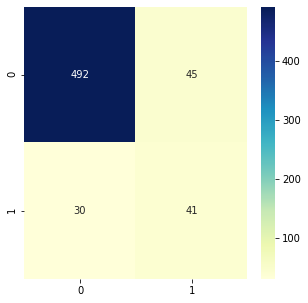

In [ ]:
cm = confusion_matrix(NR_AhR_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_AhR_score_x,NR_AhR_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

608/608 [==============================] - 0s 409us/step
Evaluation metrics:
	loss:	0.36399340193326535
	tp:	41.0
	fp:	45.0
	tn:	492.0
	fn:	30.0
	accuracy:	0.8766447305679321
	precision:	0.4767441749572754
	recall:	0.577464759349823
	auc:	0.8690429925918579



<h2>2) SMOTE </h2>

Poiché lo SMOTE genera dei dati sintetici ma non identici a quelli esistenti, in questo caso si è deciso di effettuare la cross-validation.

In [7]:
X_reshape = X.reshape(-1,16800)
sm = SMOTENC(categorical_features=[0, 41],random_state=0, sampling_strategy='minority',  k_neighbors=3)
X_res, y_res = sm.fit_resample(X_reshape, Y)
X_res = X_res.reshape(-1,400,42)

In [8]:
#X_train,X_test,y_train,y_test = train_test_split(X_res,y_res,test_size=0.2,stratify=y_res, shuffle = True)

In [9]:
print('dataset originale: ', collections.Counter(Y))
print('dataset con SMOTE: ', collections.Counter(y_res))

dataset originale:  Counter({'0': 6166, '1': 772})
dataset con SMOTE:  Counter({'0': 6166, '1': 6166})


In [12]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X_res, y_res):    
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(100, kernel_size=(10), activation='relu', padding = 'same'))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(64, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=metrics())
    
    history = modello.fit(X_res[train], y_res[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X_res[test], y_res[test]))
    
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))

    

Train on 8221 samples, validate on 4111 samples
Epoch 1/80
8221/8221 [==============================] - 8s 1ms/step - loss: 0.5561 - tp: 3282.0000 - fp: 1356.0000 - tn: 2754.0000 - fn: 829.0000 - accuracy: 0.7342 - precision: 0.7076 - recall: 0.7983 - auc: 0.7937 - val_loss: 0.5003 - val_tp: 1775.0000 - val_fp: 678.0000 - val_tn: 1378.0000 - val_fn: 280.0000 - val_accuracy: 0.7670 - val_precision: 0.7236 - val_recall: 0.8637 - val_auc: 0.8376
Epoch 2/80
8221/8221 [==============================] - 2s 263us/step - loss: 0.5036 - tp: 3386.0000 - fp: 1224.0000 - tn: 2886.0000 - fn: 725.0000 - accuracy: 0.7629 - precision: 0.7345 - recall: 0.8236 - auc: 0.8301 - val_loss: 0.4705 - val_tp: 1783.0000 - val_fp: 629.0000 - val_tn: 1427.0000 - val_fn: 272.0000 - val_accuracy: 0.7808 - val_precision: 0.7392 - val_recall: 0.8676 - val_auc: 0.8592
Epoch 3/80
8221/8221 [==============================] - 2s 254us/step - loss: 0.4687 - tp: 3421.0000 - fp: 1134.0000 - tn: 2976.0000 - fn: 690.0000 - ac

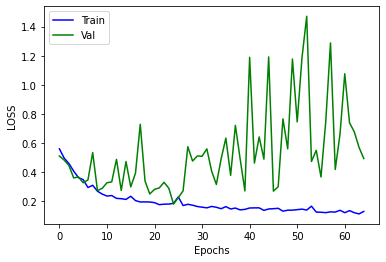

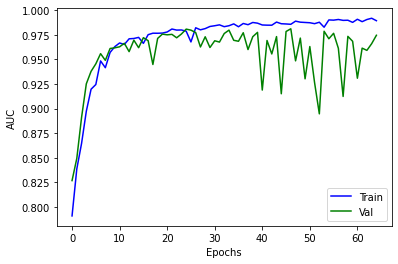

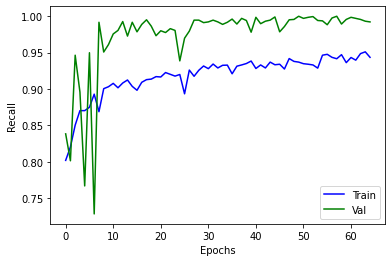

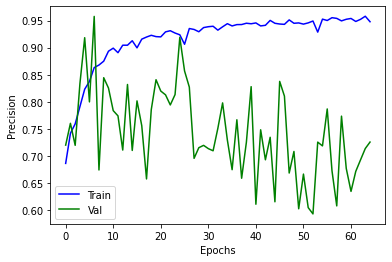

In [13]:
plot_loss(history)
plot_auc(history)
plot_rec(history)
plot_prec(history)


In [14]:
y_pred = modello.predict(NR_AhR_score_x)
y_pred = y_pred.round()
NR_AhR_score_y_int = [int(i) for i in NR_AhR_score_y]
print(classification_report(NR_AhR_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       537
           1       0.40      0.61      0.48        71

    accuracy                           0.85       608
   macro avg       0.67      0.74      0.70       608
weighted avg       0.88      0.85      0.86       608



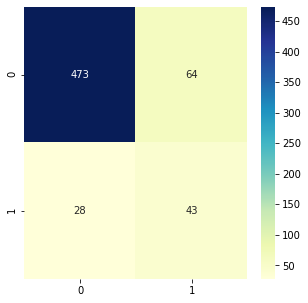

In [15]:
cm = confusion_matrix(NR_AhR_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [16]:
history_score = modello.evaluate(NR_AhR_score_x,NR_AhR_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

608/608 [==============================] - 0s 266us/step
Evaluation metrics:
	loss:	0.32261303224061666
	tp:	43.0
	fp:	64.0
	tn:	473.0
	fn:	28.0
	accuracy:	0.8486841917037964
	precision:	0.40186914801597595
	recall:	0.6056337952613831
	auc:	0.867875874042511



In [17]:
history_score = modello.evaluate(NR_AhR_score_x,NR_AhR_score_y)
print(modello.metrics_names)
history_score

608/608 [==============================] - 0s 287us/step
['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc']


[0.32261303224061666,
 43.0,
 64.0,
 473.0,
 28.0,
 0.8486841917037964,
 0.40186914801597595,
 0.6056337952613831,
 0.867875874042511]

<h1>OTTIMIZZAZIONE</h1>

<h2>1) Funzione obiettivo: Loss</h2>

In [ ]:
def create_model(filters,kernel,lr,neurons):
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(filters, kernel_size=(kernel), activation='relu', padding = 'same'))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(neurons, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=lr), metrics=metrics())

    return(modello)

In [ ]:
def model_fit(filters,kernel,lr,neurons):

    X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,stratify=Y)
    model = create_model(filters,kernel,lr,neurons)

    early_stopping = EarlyStopping(
                              monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto',
                              baseline=None, restore_best_weights=True)
    history = model.fit(X_train, y_train,
                      batch_size=256,
                      epochs=80,
                      verbose=1,
                      callbacks = [early_stopping],
                      validation_data=(X_test, y_test),
                      )
    
    evaluation = history.history['val_loss'][-1]

    print("Optimized Parameters:\n ")
    print( 'lr '+str(lr)+'\n')
    print( 'filters '+str(filters)+'\n')
    print( 'kernel '+str(kernel)+'\n')
    print( 'neurons '+str(neurons)+'\n')


    return(evaluation)

In [ ]:
def f(x):
    evaluation = model_fit(

      lr = float(x[:,0]),
      neurons = int(x[:,1]),
      filters = int(x[:,2]), 
      kernel = int(x[:,3])
       )
    score = evaluation
    print('Val_loss: ' + str(score))
    return(score)

In [ ]:
bounds = [
          {'name': 'lr', 'type': 'discrete', 'domain': (0.1,0.01,0.001,0.0001)},
          {'name': 'neurons', 'type': 'discrete', 'domain': (16,32,64,128,256,512)},
          {'name': 'filters', 'type': 'continuous', 'domain': (1,500)},
          {'name': 'kernel', 'type': 'continuous', 'domain': (1,51)},
          ]


In [ ]:
myBopt_hyp =GPyOpt.methods.BayesianOptimization(f=f,domain=bounds,initial_design_numdata = 10,model_type="GP_MCMC",acquisition_type='EI_MCMC')   

Train on 5550 samples, validate on 1388 samples
Epoch 1/80
5550/5550 [==============================] - 8s 1ms/step - loss: 0.6798 - tp: 0.0000e+00 - fp: 2.0000 - tn: 4930.0000 - fn: 618.0000 - accuracy: 0.8883 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4475 - val_loss: 0.6680 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1234.0000 - val_fn: 154.0000 - val_accuracy: 0.8890 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3808
Epoch 2/80
5550/5550 [==============================] - 1s 269us/step - loss: 0.6547 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4932.0000 - fn: 618.0000 - accuracy: 0.8886 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.3903 - val_loss: 0.6399 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1234.0000 - val_fn: 154.0000 - val_accuracy: 0.8890 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3792
Epoch 3/80
5550/5550 [==============================] - 2s 276us/step - loss: 0.6237 - tp: 0.0000e+00 - fp: 0.0000

Train on 5550 samples, validate on 1388 samples
Epoch 1/80
5550/5550 [==============================] - 3s 582us/step - loss: 0.6674 - tp: 5.0000 - fp: 36.0000 - tn: 4896.0000 - fn: 613.0000 - accuracy: 0.8831 - precision: 0.1220 - recall: 0.0081 - auc: 0.4504 - val_loss: 0.6344 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1234.0000 - val_fn: 154.0000 - val_accuracy: 0.8890 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3768
Epoch 2/80
5550/5550 [==============================] - 2s 375us/step - loss: 0.6072 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4932.0000 - fn: 618.0000 - accuracy: 0.8886 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.3838 - val_loss: 0.5692 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1234.0000 - val_fn: 154.0000 - val_accuracy: 0.8890 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3759
Epoch 3/80
5550/5550 [==============================] - 2s 380us/step - loss: 0.5489 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn

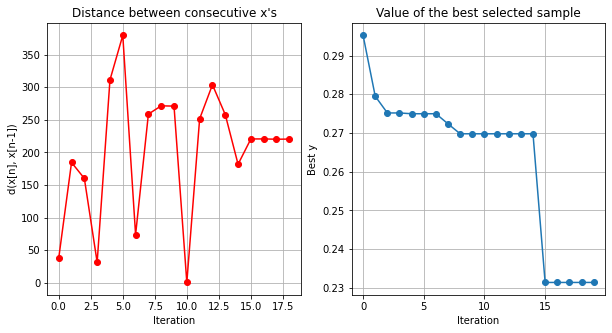

In [ ]:
myBopt_hyp.run_optimization(max_iter = 10)
x_best = myBopt_hyp.x_opt
print(x_best)
myBopt_hyp.plot_convergence()

In [ ]:
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{3}:\t{4}
\t{5}:\t{6}

""".format(bounds[0]["name"],myBopt_hyp.x_opt[0],
           bounds[1]["name"],myBopt_hyp.x_opt[1],
           bounds[2]["name"],myBopt_hyp.x_opt[2],
           bounds[3]["name"],myBopt_hyp.x_opt[3],
))
print("optimized Val_loss: {0}".format(myBopt_hyp.fx_opt))


Optimized Parameters:
	lr:	0.001
	neurons:	64.0
	64.0:	filters
	357.1526141991263:	kernel


optimized Val_loss: 0.23137403715412624


In [ ]:
bounds

[{'domain': (0.1, 0.01, 0.001, 0.0001), 'name': 'lr', 'type': 'discrete'},
 {'domain': (16, 32, 64, 128, 256, 512),
  'name': 'neurons',
  'type': 'discrete'},
 {'domain': (1, 500), 'name': 'filters', 'type': 'continuous'},
 {'domain': (1, 51), 'name': 'kernel', 'type': 'continuous'}]

In [ ]:
myBopt_hyp.x_opt

array([1.00000000e-03, 6.40000000e+01, 3.57152614e+02, 1.79436487e+01])

<h4>Addestramento del modello ottimizzato sul dataset originale:</h4>

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X,Y):    
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(357, kernel_size=(64), activation='relu', padding = 'same'))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(64, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=metrics())
    
    history = modello.fit(X[train], Y[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X[test], Y[test]))
    
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))

    

Train on 4625 samples, validate on 2313 samples
Epoch 1/80
4625/4625 [==============================] - 5s 1ms/step - loss: 0.3863 - tp: 18.0000 - fp: 238.0000 - tn: 3872.0000 - fn: 497.0000 - accuracy: 0.8411 - precision: 0.0703 - recall: 0.0350 - auc: 0.6096 - val_loss: 0.3025 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2056.0000 - val_fn: 257.0000 - val_accuracy: 0.8889 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8069
Epoch 2/80
4625/4625 [==============================] - 4s 773us/step - loss: 0.3084 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4110.0000 - fn: 515.0000 - accuracy: 0.8886 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7676 - val_loss: 0.2892 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2056.0000 - val_fn: 257.0000 - val_accuracy: 0.8889 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8231
Epoch 3/80
4625/4625 [==============================] - 4s 773us/step - loss: 0.2911 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn

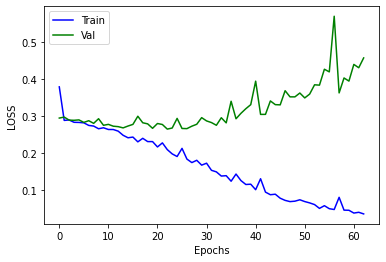

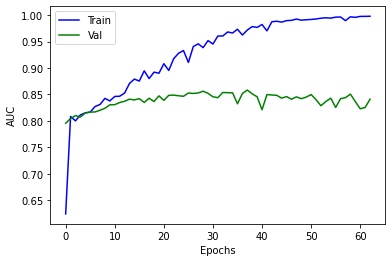

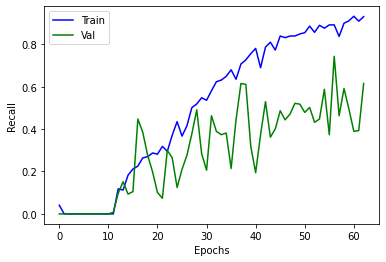

In [ ]:
plot_loss(history)
plot_auc(history)
plot_rec(history)


In [ ]:
y_pred = modello.predict(NR_AhR_score_x)
y_pred = y_pred.round()
NR_AhR_score_y_int = [int(i) for i in NR_AhR_score_y]
print(classification_report(NR_AhR_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       537
           1       0.49      0.45      0.47        71

    accuracy                           0.88       608
   macro avg       0.71      0.69      0.70       608
weighted avg       0.88      0.88      0.88       608



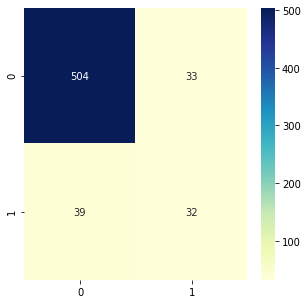

In [ ]:
cm = confusion_matrix(NR_AhR_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_AhR_score_x,NR_AhR_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

608/608 [==============================] - 0s 386us/step
Evaluation metrics:
	loss:	0.27755099142852585
	tp:	32.0
	fp:	33.0
	tn:	504.0
	fn:	39.0
	accuracy:	0.8815789222717285
	precision:	0.4923076927661896
	recall:	0.4507042169570923
	auc:	0.8595221042633057



<h4>Addestramento del modello ottimizzato su dataset SMOTE: </h4>

In [7]:
X_reshape = X.reshape(-1,16800)
sm = SMOTENC(categorical_features=[0,41],random_state=0, sampling_strategy='minority',  k_neighbors=2)
X_res, y_res = sm.fit_resample(X_reshape, Y)
X_res = X_res.reshape(-1,400,42)

In [8]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X_res,y_res):    
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(357, kernel_size=(64), activation='relu', padding = 'same'))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(64, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=metrics())
    
    history = modello.fit(X_res[train], y_res[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X_res[test], y_res[test]))
    
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))

    

Train on 8221 samples, validate on 4111 samples
Epoch 1/80
8221/8221 [==============================] - 14s 2ms/step - loss: 0.5401 - tp: 3315.0000 - fp: 1393.0000 - tn: 2717.0000 - fn: 796.0000 - accuracy: 0.7337 - precision: 0.7041 - recall: 0.8064 - auc: 0.8033 - val_loss: 0.4863 - val_tp: 1705.0000 - val_fp: 647.0000 - val_tn: 1409.0000 - val_fn: 350.0000 - val_accuracy: 0.7575 - val_precision: 0.7249 - val_recall: 0.8297 - val_auc: 0.8435
Epoch 2/80
8221/8221 [==============================] - 6s 786us/step - loss: 0.4543 - tp: 3447.0000 - fp: 1067.0000 - tn: 3043.0000 - fn: 664.0000 - accuracy: 0.7894 - precision: 0.7636 - recall: 0.8385 - auc: 0.8654 - val_loss: 0.4047 - val_tp: 1869.0000 - val_fp: 530.0000 - val_tn: 1526.0000 - val_fn: 186.0000 - val_accuracy: 0.8258 - val_precision: 0.7791 - val_recall: 0.9095 - val_auc: 0.9002
Epoch 3/80
8221/8221 [==============================] - 6s 790us/step - loss: 0.4157 - tp: 3434.0000 - fp: 866.0000 - tn: 3244.0000 - fn: 677.0000 - ac

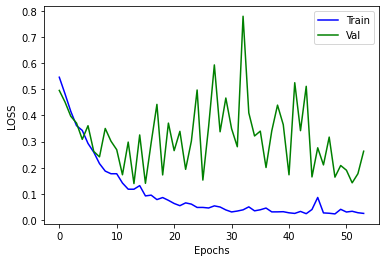

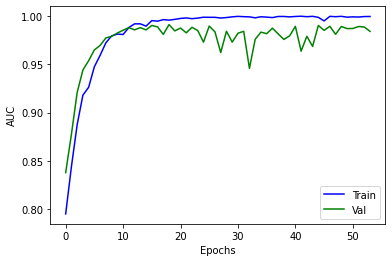

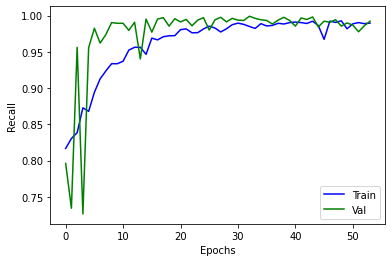

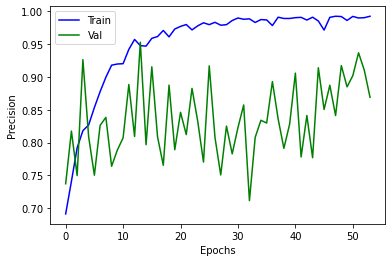

In [9]:
plot_loss(history)
plot_auc(history)
plot_rec(history)
plot_prec(history)


In [10]:
y_pred = modello.predict(NR_AhR_score_x)
y_pred = y_pred.round()
NR_AhR_score_y_int = [int(i) for i in NR_AhR_score_y]
print(classification_report(NR_AhR_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       537
           1       0.51      0.62      0.56        71

    accuracy                           0.88       608
   macro avg       0.73      0.77      0.75       608
weighted avg       0.90      0.88      0.89       608



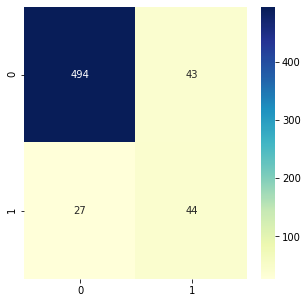

In [11]:
cm = confusion_matrix(NR_AhR_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [12]:
history_score = modello.evaluate(NR_AhR_score_x,NR_AhR_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

608/608 [==============================] - 0s 330us/step
Evaluation metrics:
	loss:	0.3094144370406866
	tp:	44.0
	fp:	43.0
	tn:	494.0
	fn:	27.0
	accuracy:	0.8848684430122375
	precision:	0.5057471394538879
	recall:	0.6197183132171631
	auc:	0.880189836025238



<h2>2) Funzione da ottimizzare: F2Score</h2>

In [ ]:
def create_model(filters,kernel,lr,neurons):
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(filters, kernel_size=(kernel), activation='relu', padding = 'same'))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(neurons, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=lr), metrics=metrics())

    return(modello)

In [ ]:
def model_fit(filters,kernel,lr,neurons):

    X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,stratify=Y)
    model = create_model(filters,kernel,lr,neurons)

    early_stopping = EarlyStopping(
                              monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto',
                              baseline=None, restore_best_weights=True)
    history = model.fit(X_train, y_train,
                      batch_size=256,
                      epochs=80,
                      verbose=1,
                      callbacks = [early_stopping],
                      validation_data=(X_test, y_test),
                      )
    
    try:
      evaluation = (5*history.history['val_precision'][-1]*history.history['val_recall'][-1])/((4*history.history['val_precision'][-1])+history.history['val_recall'][-1])
    except:
      evaluation = 0
      

    print("Optimized Parameters:\n ")
    print( 'lr '+str(lr)+'\n')
    print( 'filters '+str(filters)+'\n')
    print( 'kernel '+str(kernel)+'\n')
    print( 'neurons '+str(neurons)+'\n')


    return(evaluation)

In [ ]:
def f(x):
    evaluation = model_fit(

      lr = float(x[:,0]),
      neurons = int(x[:,1]),
      filters = int(x[:,2]), 
      kernel = int(x[:,3])
       )
    score = evaluation
    print('Val_F2Score: ' + str(score))
    return(-score)

In [ ]:
bounds = [
          {'name': 'lr', 'type': 'discrete', 'domain': (0.1,0.01,0.001,0.0001)},
          {'name': 'neurons', 'type': 'discrete', 'domain': (16,32,64,128,256,512)},
          {'name': 'filters', 'type': 'continuous', 'domain': (1,500)},
          {'name': 'kernel', 'type': 'continuous', 'domain': (1,51)},
          ]


In [ ]:
myBopt_hyp =GPyOpt.methods.BayesianOptimization(f=f,domain=bounds,initial_design_numdata = 10,model_type="GP_MCMC",acquisition_type='EI_MCMC')   

Train on 5550 samples, validate on 1388 samples
Epoch 1/80
5550/5550 [==============================] - 8s 1ms/step - loss: 0.6804 - tp: 0.0000e+00 - fp: 2.0000 - tn: 4930.0000 - fn: 618.0000 - accuracy: 0.8883 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4457 - val_loss: 0.6686 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1234.0000 - val_fn: 154.0000 - val_accuracy: 0.8890 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3923
Epoch 2/80
5550/5550 [==============================] - 1s 146us/step - loss: 0.6551 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4932.0000 - fn: 618.0000 - accuracy: 0.8886 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.3922 - val_loss: 0.6402 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1234.0000 - val_fn: 154.0000 - val_accuracy: 0.8890 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3782
Epoch 3/80
5550/5550 [==============================] - 1s 141us/step - loss: 0.6238 - tp: 0.0000e+00 - fp: 0.0000

reconstraining parameters GP_regression.rbf
reconstraining parameters GP_regression.Gaussian_noise.variance


Train on 5550 samples, validate on 1388 samples
Epoch 1/80
5550/5550 [==============================] - 1s 252us/step - loss: 0.4912 - tp: 26.0000 - fp: 222.0000 - tn: 4710.0000 - fn: 592.0000 - accuracy: 0.8533 - precision: 0.1048 - recall: 0.0421 - auc: 0.5917 - val_loss: 0.3088 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1234.0000 - val_fn: 154.0000 - val_accuracy: 0.8890 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7800
Epoch 2/80
5550/5550 [==============================] - 1s 188us/step - loss: 0.2994 - tp: 29.0000 - fp: 11.0000 - tn: 4921.0000 - fn: 589.0000 - accuracy: 0.8919 - precision: 0.7250 - recall: 0.0469 - auc: 0.7733 - val_loss: 0.3031 - val_tp: 59.0000 - val_fp: 87.0000 - val_tn: 1147.0000 - val_fn: 95.0000 - val_accuracy: 0.8689 - val_precision: 0.4041 - val_recall: 0.3831 - val_auc: 0.8223
Epoch 3/80
5550/5550 [==============================] - 1s 183us/step - loss: 0.2883 - tp: 41.0000 - fp: 43.0000 - tn: 4889.0000 - fn: 577.0000 - accu

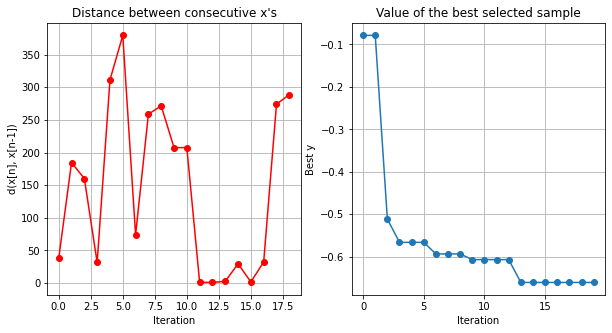

In [ ]:
myBopt_hyp.run_optimization(max_iter = 10)
x_best = myBopt_hyp.x_opt
print(x_best)
myBopt_hyp.plot_convergence()

In [ ]:
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}

""".format(bounds[0]["name"],myBopt_hyp.x_opt[0],
           bounds[1]["name"],myBopt_hyp.x_opt[1],
           bounds[3]["name"],myBopt_hyp.x_opt[3],
           bounds[2]["name"],myBopt_hyp.x_opt[2],
))
print("optimized Val_F2Score: {0}".format(myBopt_hyp.fx_opt))


Optimized Parameters:
	lr:	0.001
	neurons:	256.0
	kernel:	23.458316595958117
	filters:	308.76713251520124


optimized Val_F2Score: -0.6609195550778907


In [ ]:
bounds

[{'domain': (0.1, 0.01, 0.001, 0.0001), 'name': 'lr', 'type': 'discrete'},
 {'domain': (16, 32, 64, 128, 256, 512),
  'name': 'neurons',
  'type': 'discrete'},
 {'domain': (1, 500), 'name': 'filters', 'type': 'continuous'},
 {'domain': (1, 51), 'name': 'kernel', 'type': 'continuous'}]

In [ ]:
myBopt_hyp.x_opt

array([1.00000000e-03, 2.56000000e+02, 3.08767133e+02, 2.34583166e+01])

<h4>Addestramento del modello ottimizzato sul dataset originale: </h4>

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X,Y):    
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(309, kernel_size=(24), activation='relu', padding = 'same'))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(256, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=metrics())
    
    history = modello.fit(X[train], Y[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X[test], Y[test]))
    
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))

    

Train on 4625 samples, validate on 2313 samples
Epoch 1/80
4625/4625 [==============================] - 2s 333us/step - loss: 0.5198 - tp: 1.0000 - fp: 84.0000 - tn: 4026.0000 - fn: 514.0000 - accuracy: 0.8707 - precision: 0.0118 - recall: 0.0019 - auc: 0.4564 - val_loss: 0.4317 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2056.0000 - val_fn: 257.0000 - val_accuracy: 0.8889 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3953
Epoch 2/80
4625/4625 [==============================] - 1s 230us/step - loss: 0.3806 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4110.0000 - fn: 515.0000 - accuracy: 0.8886 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4976 - val_loss: 0.3466 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2056.0000 - val_fn: 257.0000 - val_accuracy: 0.8889 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6229
Epoch 3/80
4625/4625 [==============================] - 1s 227us/step - loss: 0.3255 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn

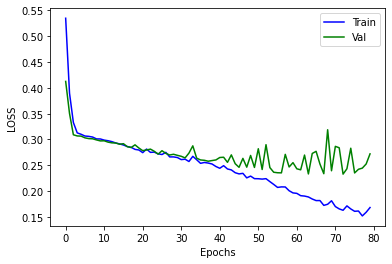

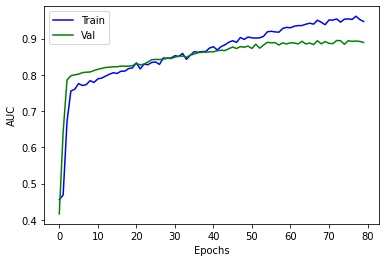

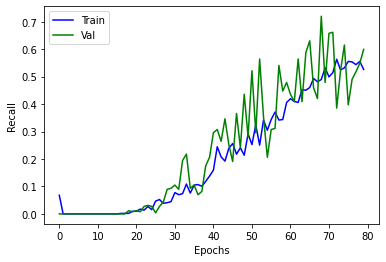

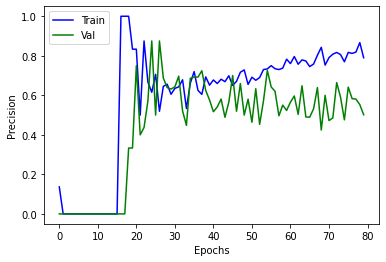

In [ ]:
plot_loss(history)
plot_auc(history)
plot_rec(history)
plot_prec(history)


In [ ]:
y_pred = modello.predict(NR_AhR_score_x)
y_pred = y_pred.round()
NR_AhR_score_y_int = [int(i) for i in NR_AhR_score_y]
print(classification_report(NR_AhR_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       537
           1       0.45      0.75      0.56        71

    accuracy                           0.87       608
   macro avg       0.71      0.81      0.74       608
weighted avg       0.90      0.87      0.88       608



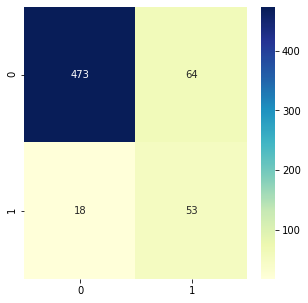

In [ ]:
cm = confusion_matrix(NR_AhR_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_AhR_score_x,NR_AhR_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

608/608 [==============================] - 0s 183us/step
Evaluation metrics:
	loss:	0.33304735547617864
	tp:	53.0
	fp:	64.0
	tn:	473.0
	fn:	18.0
	accuracy:	0.8651315569877625
	precision:	0.45299145579338074
	recall:	0.7464788556098938
	auc:	0.8743148446083069



<h4>Addestramento del modello ottimizzato sul dataset SMOTE:</h4>

In [ ]:
X_reshape = X.reshape(-1,16800)
sm = SMOTENC(categorical_features=[0, 41],random_state=0, sampling_strategy='minority',  k_neighbors=3)
X_res, y_res = sm.fit_resample(X_reshape, Y)
X_res = X_res.reshape(-1,400,42)

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X_res,y_res):    
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(309, kernel_size=(24), activation='relu', padding = 'same'))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(256, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=metrics())
    
    history = modello.fit(X_res[train], y_res[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X_res[test], y_res[test]))
    
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))

    

Train on 8221 samples, validate on 4111 samples
Epoch 1/80
8221/8221 [==============================] - 9s 1ms/step - loss: 0.5920 - tp: 3403.0000 - fp: 1511.0000 - tn: 2599.0000 - fn: 708.0000 - accuracy: 0.7301 - precision: 0.6925 - recall: 0.8278 - auc: 0.7750 - val_loss: 0.5385 - val_tp: 1762.0000 - val_fp: 788.0000 - val_tn: 1268.0000 - val_fn: 293.0000 - val_accuracy: 0.7370 - val_precision: 0.6910 - val_recall: 0.8574 - val_auc: 0.8129
Epoch 2/80
8221/8221 [==============================] - 2s 227us/step - loss: 0.5252 - tp: 3228.0000 - fp: 1201.0000 - tn: 2909.0000 - fn: 883.0000 - accuracy: 0.7465 - precision: 0.7288 - recall: 0.7852 - auc: 0.8169 - val_loss: 0.5230 - val_tp: 1777.0000 - val_fp: 777.0000 - val_tn: 1279.0000 - val_fn: 278.0000 - val_accuracy: 0.7434 - val_precision: 0.6958 - val_recall: 0.8647 - val_auc: 0.8215
Epoch 3/80
8221/8221 [==============================] - 2s 225us/step - loss: 0.5138 - tp: 3387.0000 - fp: 1272.0000 - tn: 2838.0000 - fn: 724.0000 - ac

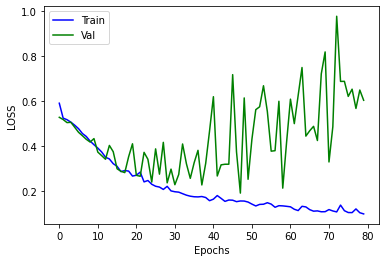

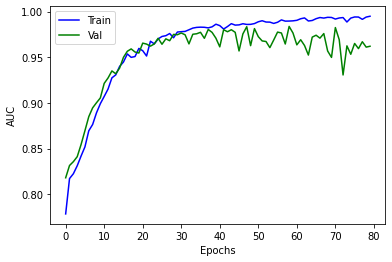

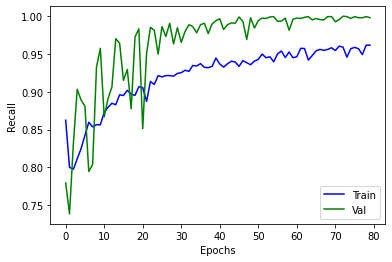

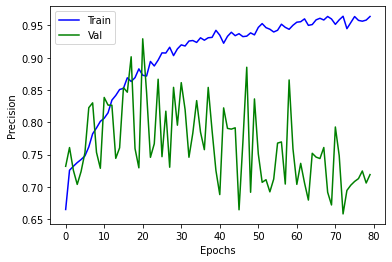

In [ ]:
plot_loss(history)
plot_auc(history)
plot_rec(history)
plot_prec(history)


In [ ]:
y_pred = modello.predict(NR_AhR_score_x)
y_pred = y_pred.round()
NR_AhR_score_y_int = [int(i) for i in NR_AhR_score_y]
print(classification_report(NR_AhR_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.99      0.57      0.72       537
           1       0.23      0.96      0.37        71

    accuracy                           0.61       608
   macro avg       0.61      0.76      0.54       608
weighted avg       0.90      0.61      0.68       608



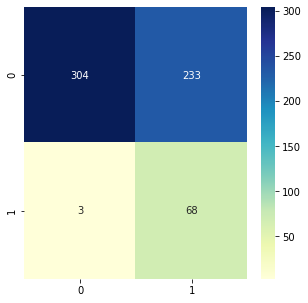

In [ ]:
cm = confusion_matrix(NR_AhR_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_AhR_score_x,NR_AhR_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

608/608 [==============================] - 0s 166us/step
Evaluation metrics:
	loss:	1.2758015017760427
	tp:	68.0
	fp:	233.0
	tn:	304.0
	fn:	3.0
	accuracy:	0.6118420958518982
	precision:	0.2259136140346527
	recall:	0.9577465057373047
	auc:	0.8658300638198853



<h3>3) Funzione da ottimizzare: F1Score</h3>

In [ ]:
def create_model(filters,kernel,lr,neurons):
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(filters, kernel_size=(kernel), activation='relu', padding = 'same'))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(neurons, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=lr), metrics=metrics())

    return(modello)

In [ ]:
def model_fit(filters,kernel,lr,neurons):

    X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,stratify=Y)
    model = create_model(filters,kernel,lr,neurons)

    early_stopping = EarlyStopping(
                              monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto',
                              baseline=None, restore_best_weights=True)
    history = model.fit(X_train, y_train,
                      batch_size=256,
                      epochs=80,
                      verbose=1,
                      callbacks = [early_stopping],
                      validation_data=(X_test, y_test),
                      )
    
    try:
      evaluation = (2*history.history['val_precision'][-1]*history.history['val_recall'][-1])/((history.history['val_precision'][-1])+history.history['val_recall'][-1])
    except:
      evaluation = 0
      

    print("Optimized Parameters:\n ")
    print( 'lr '+str(lr)+'\n')
    print( 'filters '+str(filters)+'\n')
    print( 'kernel '+str(kernel)+'\n')
    print( 'neurons '+str(neurons)+'\n')


    return(evaluation)

In [ ]:
def f(x):
    evaluation = model_fit(

      lr = float(x[:,0]),
      neurons = int(x[:,1]),
      filters = int(x[:,2]), 
      kernel = int(x[:,3])
       )
    score = evaluation
    print('Val_F1Score: ' + str(score))
    return(-score)

In [ ]:
bounds = [
          {'name': 'lr', 'type': 'discrete', 'domain': (0.1,0.01,0.001,0.0001)},
          {'name': 'neurons', 'type': 'discrete', 'domain': (16,32,64,128,256,512)},
          {'name': 'filters', 'type': 'continuous', 'domain': (1,500)},
          {'name': 'kernel', 'type': 'continuous', 'domain': (1,51)},
          ]


In [ ]:
myBopt_hyp =GPyOpt.methods.BayesianOptimization(f=f,domain=bounds,initial_design_numdata = 10,model_type="GP_MCMC",acquisition_type='EI_MCMC')   

Train on 5550 samples, validate on 1388 samples
Epoch 1/80
5550/5550 [==============================] - 8s 1ms/step - loss: 0.6798 - tp: 0.0000e+00 - fp: 2.0000 - tn: 4930.0000 - fn: 618.0000 - accuracy: 0.8883 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4475 - val_loss: 0.6680 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1234.0000 - val_fn: 154.0000 - val_accuracy: 0.8890 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3808
Epoch 2/80
5550/5550 [==============================] - 1s 153us/step - loss: 0.6547 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4932.0000 - fn: 618.0000 - accuracy: 0.8886 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.3903 - val_loss: 0.6399 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1234.0000 - val_fn: 154.0000 - val_accuracy: 0.8890 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3792
Epoch 3/80
5550/5550 [==============================] - 1s 152us/step - loss: 0.6237 - tp: 0.0000e+00 - fp: 0.0000

reconstraining parameters GP_regression.rbf
reconstraining parameters GP_regression.Gaussian_noise.variance


Train on 5550 samples, validate on 1388 samples
Epoch 1/80
5550/5550 [==============================] - 1s 252us/step - loss: 0.3823 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4932.0000 - fn: 618.0000 - accuracy: 0.8886 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5995 - val_loss: 0.3136 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1234.0000 - val_fn: 154.0000 - val_accuracy: 0.8890 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7909
Epoch 2/80
5550/5550 [==============================] - 1s 200us/step - loss: 0.3108 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4932.0000 - fn: 618.0000 - accuracy: 0.8886 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7468 - val_loss: 0.2987 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1234.0000 - val_fn: 154.0000 - val_accuracy: 0.8890 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8006
Epoch 3/80
5550/5550 [==============================] - 1s 198us/step - loss: 0.3018 - tp: 0.0000e+00 - fp: 

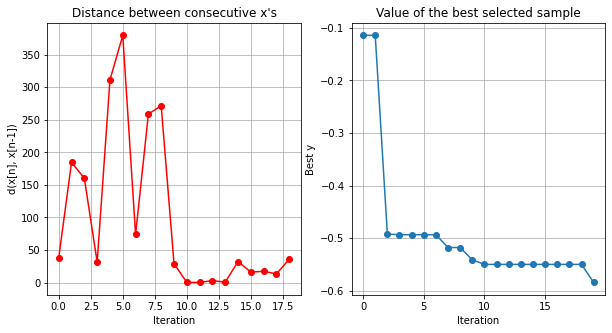

In [ ]:
myBopt_hyp.run_optimization(max_iter = 10)
x_best = myBopt_hyp.x_opt
print(x_best)
myBopt_hyp.plot_convergence()

In [ ]:
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}

""".format(bounds[0]["name"],myBopt_hyp.x_opt[0],
           bounds[1]["name"],myBopt_hyp.x_opt[1],
           bounds[3]["name"],myBopt_hyp.x_opt[3],
           bounds[2]["name"],myBopt_hyp.x_opt[2],
))
print("optimized Val_F1Score: {0}".format(myBopt_hyp.fx_opt))


Optimized Parameters:
	lr:	0.001
	neurons:	256.0
	kernel:	34.68512591453892
	filters:	275.63429065261465


optimized Val_F1Score: -0.58421053006048


In [ ]:
bounds

[{'domain': (0.1, 0.01, 0.001, 0.0001), 'name': 'lr', 'type': 'discrete'},
 {'domain': (16, 32, 64, 128, 256, 512),
  'name': 'neurons',
  'type': 'discrete'},
 {'domain': (1, 500), 'name': 'filters', 'type': 'continuous'},
 {'domain': (1, 51), 'name': 'kernel', 'type': 'continuous'}]

In [ ]:
myBopt_hyp.x_opt

array([1.00000000e-03, 2.56000000e+02, 2.75634291e+02, 3.46851259e+01])

<h4>Addestramento del modello ottimizzato sul dataset originale:</h4>

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X,Y):    
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(276, kernel_size=(34), activation='relu', padding = 'same'))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(256, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=metrics())
    
    history = modello.fit(X[train], Y[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X[test], Y[test]))
    
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))

    

Train on 4625 samples, validate on 2313 samples
Epoch 1/80
4625/4625 [==============================] - 9s 2ms/step - loss: 0.5204 - tp: 28.0000 - fp: 228.0000 - tn: 3882.0000 - fn: 487.0000 - accuracy: 0.8454 - precision: 0.1094 - recall: 0.0544 - auc: 0.4668 - val_loss: 0.4237 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2056.0000 - val_fn: 257.0000 - val_accuracy: 0.8889 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4097
Epoch 2/80
4625/4625 [==============================] - 1s 306us/step - loss: 0.3910 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4110.0000 - fn: 515.0000 - accuracy: 0.8886 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4873 - val_loss: 0.3401 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2056.0000 - val_fn: 257.0000 - val_accuracy: 0.8889 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6508
Epoch 3/80
4625/4625 [==============================] - 1s 296us/step - loss: 0.3278 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn

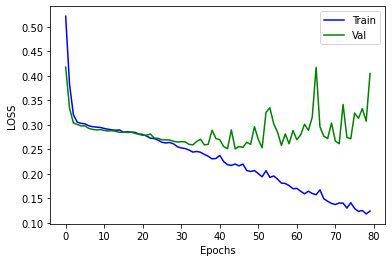

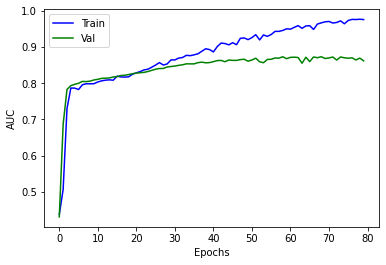

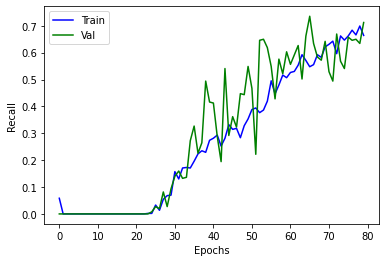

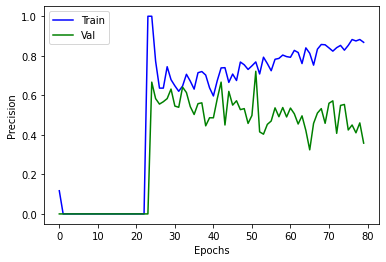

In [ ]:
plot_loss(history)
plot_auc(history)
plot_rec(history)
plot_prec(history)


In [ ]:
y_pred = modello.predict(NR_AhR_score_x)
y_pred = y_pred.round()
NR_AhR_score_y_int = [int(i) for i in NR_AhR_score_y]
print(classification_report(NR_AhR_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87       537
           1       0.35      0.83      0.49        71

    accuracy                           0.80       608
   macro avg       0.66      0.81      0.68       608
weighted avg       0.90      0.80      0.83       608



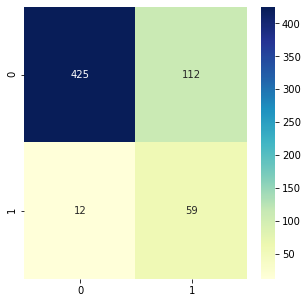

In [ ]:
cm = confusion_matrix(NR_AhR_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_AhR_score_x,NR_AhR_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

608/608 [==============================] - 0s 186us/step
Evaluation metrics:
	loss:	0.46102788848312276
	tp:	59.0
	fp:	112.0
	tn:	425.0
	fn:	12.0
	accuracy:	0.7960526347160339
	precision:	0.34502923488616943
	recall:	0.8309859037399292
	auc:	0.8677970767021179



<h4>Addestramento del modello ottimizzato su dataset SMOTE:</h4>

In [ ]:
X_reshape = X.reshape(-1,16800)
sm = SMOTENC(categorical_features=[0, 41],random_state=0, sampling_strategy='minority',  k_neighbors=3)
X_res, y_res = sm.fit_resample(X_reshape, Y)
X_res = X_res.reshape(-1,400,42)

In [ ]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
#train scores
cvscores_train_loss = []
cvscores_train_auc = []
cvscores_train_rec = []
cvscores_train_prec = []

#validation scores
cvscores_val_loss = []
cvscores_val_auc = []
cvscores_val_rec = []
cvscores_val_prec = []

for train, test in kfold.split(X_res,y_res):    
    
    modello = Sequential()
    modello.add(Dropout(0.25))
    modello.add(Conv1D(276, kernel_size=(34), activation='relu', padding = 'same'))
    modello.add(GlobalAveragePooling1D())
    modello.add(Dense(256, activation='relu'))
    modello.add(Dropout(0,5))
    modello.add(Dense(1, activation='sigmoid'))

    early_stopping = EarlyStopping(
                                  monitor='val_loss', min_delta=0, patience=40, verbose=0, mode='auto',
                                  baseline=None, restore_best_weights=True)


    modello.compile(loss=keras.losses.BinaryCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=metrics())
    
    history = modello.fit(X_res[train], y_res[train],
                        batch_size=256,
                        epochs=80,
                        verbose=1,
                        callbacks = [early_stopping],
                        validation_data = (X_res[test], y_res[test]))
    
    cvscores_train_loss.append(history.history['loss'][-1])
    cvscores_train_auc.append(history.history['auc'][-1])
    cvscores_train_rec.append(history.history['recall'][-1])   
    cvscores_train_prec.append(history.history['precision'][-1])

    cvscores_val_loss.append(history.history['val_loss'][-1])
    cvscores_val_auc.append(history.history['val_auc'][-1])
    cvscores_val_rec.append(history.history['val_recall'][-1])   
    cvscores_val_prec.append(history.history['val_precision'][-1])

print("Loss: ",np.mean(cvscores_val_loss),' +/- ' ,np.std(cvscores_val_loss))
print("AUC: ",np.mean(cvscores_val_auc),' +/- ',np.std(cvscores_val_auc))
print("Recall: ",np.mean(cvscores_val_rec),' +/- ',np.std(cvscores_val_rec))
print("Precision: ",np.mean(cvscores_val_prec),' +/- ',np.std(cvscores_val_prec))

    

Train on 8221 samples, validate on 4111 samples
Epoch 1/80
8221/8221 [==============================] - 10s 1ms/step - loss: 0.5864 - tp: 3321.0000 - fp: 1423.0000 - tn: 2687.0000 - fn: 790.0000 - accuracy: 0.7308 - precision: 0.7000 - recall: 0.8078 - auc: 0.7782 - val_loss: 0.5386 - val_tp: 1765.0000 - val_fp: 786.0000 - val_tn: 1270.0000 - val_fn: 290.0000 - val_accuracy: 0.7383 - val_precision: 0.6919 - val_recall: 0.8589 - val_auc: 0.8127
Epoch 2/80
8221/8221 [==============================] - 2s 283us/step - loss: 0.5262 - tp: 3229.0000 - fp: 1209.0000 - tn: 2901.0000 - fn: 882.0000 - accuracy: 0.7457 - precision: 0.7276 - recall: 0.7855 - auc: 0.8166 - val_loss: 0.5278 - val_tp: 1803.0000 - val_fp: 807.0000 - val_tn: 1249.0000 - val_fn: 252.0000 - val_accuracy: 0.7424 - val_precision: 0.6908 - val_recall: 0.8774 - val_auc: 0.8204
Epoch 3/80
8221/8221 [==============================] - 2s 282us/step - loss: 0.5144 - tp: 3382.0000 - fp: 1290.0000 - tn: 2820.0000 - fn: 729.0000 - a

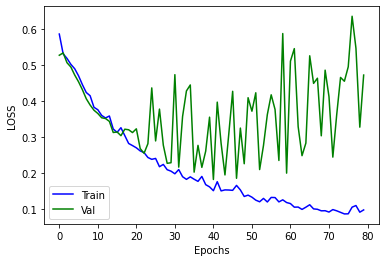

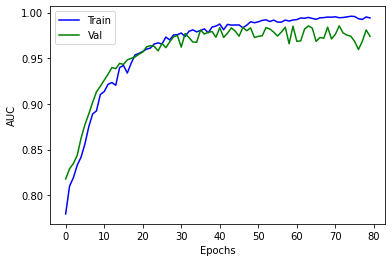

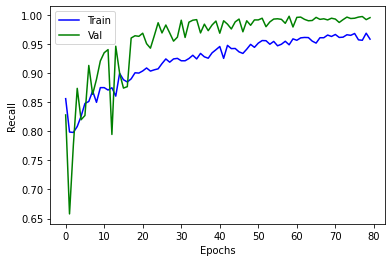

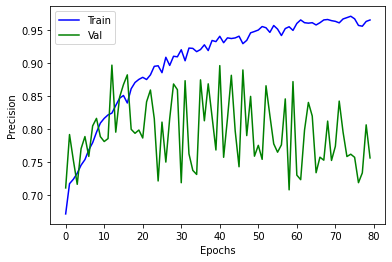

In [ ]:
plot_loss(history)
plot_auc(history)
plot_rec(history)
plot_prec(history)


In [ ]:
y_pred = modello.predict(NR_AhR_score_x)
y_pred = y_pred.round()
NR_AhR_score_y_int = [int(i) for i in NR_AhR_score_y]
print(classification_report(NR_AhR_score_y_int,y_pred, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.99      0.62      0.76       537
           1       0.25      0.94      0.39        71

    accuracy                           0.66       608
   macro avg       0.62      0.78      0.58       608
weighted avg       0.90      0.66      0.72       608



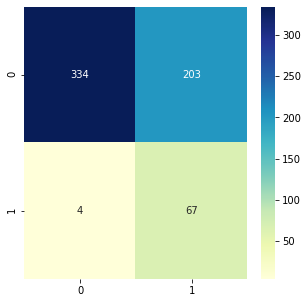

In [ ]:
cm = confusion_matrix(NR_AhR_score_y_int,y_pred)
plt.subplots(figsize=(5,5))
sbn.heatmap(cm, annot=True,fmt='g',cmap="YlGnBu")

In [ ]:
history_score = modello.evaluate(NR_AhR_score_x,NR_AhR_score_y)
print("""Evaluation metrics:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
\t{12}:\t{13}
\t{14}:\t{15}
\t{16}:\t{17}
""".format(modello.metrics_names[0],history_score[0],
           modello.metrics_names[1],history_score[1],
           modello.metrics_names[2],history_score[2],
           modello.metrics_names[3],history_score[3],
           modello.metrics_names[4],history_score[4],
           modello.metrics_names[5],history_score[5],
           modello.metrics_names[6],history_score[6],
           modello.metrics_names[7],history_score[7],
           modello.metrics_names[8],history_score[8]
          
          
))

608/608 [==============================] - 0s 185us/step
Evaluation metrics:
	loss:	1.099677114110244
	tp:	67.0
	fp:	203.0
	tn:	334.0
	fn:	4.0
	accuracy:	0.6595394611358643
	precision:	0.2481481432914734
	recall:	0.9436619877815247
	auc:	0.8717706203460693

